In [9]:
import os
import glob
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import silence_tensorflow.auto
import tensorflow as tf
import io
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

In [10]:
H=512 # height
W=512 # width  
C=3 # channels
h=4 # heads

P=16 # patch size
assert(H == W)
assert(H%P == 0)

D_model=512 # transformer latent dim
D_head = D_model/h #dim of each head
D_fcn=2048 # FCN hidden dim
num_layers=4 # transformer depth
BS=4 # batch size
N=int((H*W)/(P*P)) # Number of patches

In [73]:
FLOAT=tf.float16

In [74]:
def load_and_validate(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=C, expand_animations=False)
    img = tf.divide(tf.cast(img, dtype=FLOAT), 255.0)
    is_valid = tf.reduce_all(tf.equal(tf.shape(img), tf.constant((H,W,C))))
    
    return img, is_valid

dataset_path = "/mnt/Data/ML/datasets/portraits"
num_samples = 50


all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.png'))]
random.shuffle(all_files)
selected_files = all_files[:num_samples]
dataset = tf.data.Dataset.from_tensor_slices(selected_files)
dataset = dataset.map(load_and_validate, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.filter(lambda img, is_valid: is_valid)  # Keep valid images
dataset = dataset.map(lambda img, is_valid: img) # remove unused feature
dataset = dataset.map(lambda img: tf.ensure_shape(img, (H, W, C)))
print(f"Total files: {len(selected_files)}")
valid_count = dataset.reduce(tf.constant(0), lambda x, _: x + 1).numpy()
print(f"Valid images count: {valid_count}")
assert(valid_count), "Everything's gone"

Total files: 50
Valid images count: 50


In [76]:
def visualize_unbatched_dataset(dataset: tf.data.Dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i, (image) in enumerate(dataset.take(num_images)):  # Extract each sample
        ax = axes[i] if num_images > 1 else axes
        image = tf.cast(image,dtype=tf.float32)
        ax.imshow(image.numpy().squeeze(), cmap='gray')  # Adjust based on dataset shape
        ax.axis("off")
    
    plt.show()


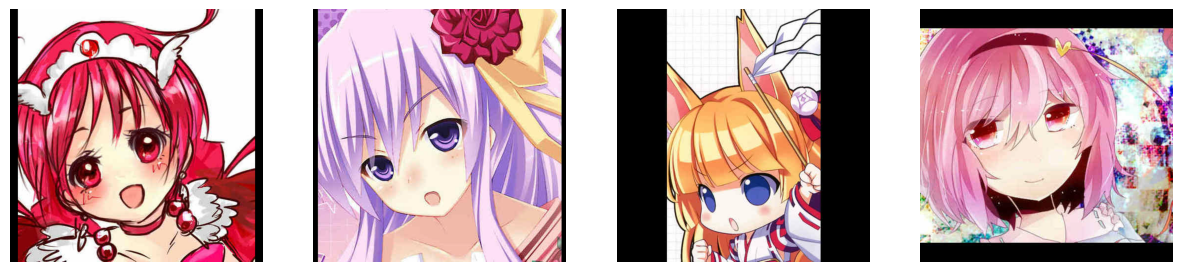

In [81]:
visualize_unbatched_dataset(dataset, 4)

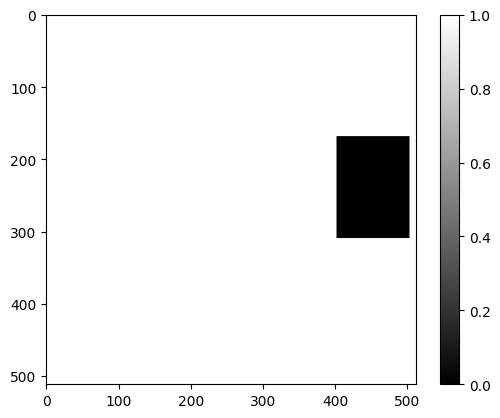

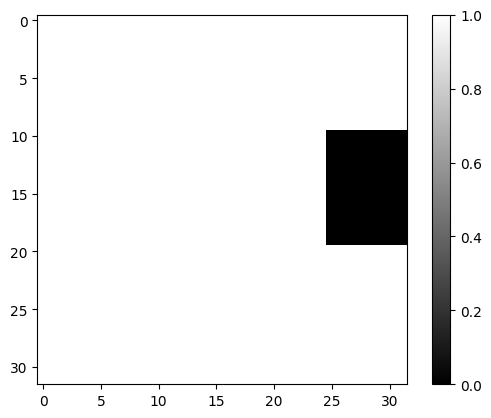

InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 1024 values, but the requested shape has 4096 [Op:Reshape]

In [338]:
def random_visibility_mask():
    x1 = tf.random.uniform(shape=(), minval=0, maxval=W - 100, dtype=tf.int32)
    y1 = tf.random.uniform(shape=(), minval=0, maxval=H-100, dtype=tf.int32)
    x2 = tf.random.uniform(shape=(), minval=x1 + 100, maxval=W + 1, dtype=tf.int32)
    y2 = tf.random.uniform(shape=(), minval=y1 + 100, maxval=H + 1, dtype=tf.int32)
    # tf.print(x1,x2,y1,y2)
    
    mask = tf.ones((H, W), dtype=tf.bool)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=tf.stack([tf.repeat(tf.range(y1, y2), x2 - x1), tf.tile(tf.range(x1, x2), [y2 - y1])], axis=-1),
        updates=tf.zeros([ (y2 - y1) * (x2 - x1) ], dtype=tf.bool)
    )
    return mask

def mask_area(mask):
    return tf.reduce_sum(tf.cast(tf.logical_not(mask), tf.float32)) 

def viz_mask(mask):
    plt.imshow(tf.squeeze(mask).numpy(), cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

def visualize_mask_on_image(image, mask):
    tf.print(mask_area(mask))

    # Ensure both image and mask are in float32 format
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)

    mask_expanded = tf.expand_dims(mask, axis=-1)
    masked_image = tf.multiply(image, mask_expanded)

    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(image.numpy() , cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    # Plot masked image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(masked_image.numpy(), cmap='gray')
    plt.title("Masked Image")
    plt.axis("off")

    # Show both plots
    plt.tight_layout()
    plt.show()


def extract_patches(image: tf.Tensor) -> tf.Tensor:
    # R^{BS x H x W x C} -> R^{BS x N x P^2 x C}
    patches = tf.image.extract_patches(
        images=image,  # Add batch dim
        sizes=[1, P, P, 1],  # Patch size
        strides=[1, P, P, 1],  # Step size
        rates=[1, 1, 1, 1],  # No dilation
        padding='VALID'
    )
    patches = tf.reshape(patches, [N, P*P, C])  # Reshape to (N, P^2, C)
    return patches

def process_mask(mask: tf.Tensor):
    # R^{BS x H x W} -> tuple[R^{BS x N}, R^{BS x N x N}]
    viz_mask(mask)
    mask = tf.expand_dims(mask, axis=-1)  #  add channel dimension
    mask_pooled = tf.nn.max_pool2d(
            tf.cast(tf.logical_not(mask), dtype=tf.int8), #insane shit happaned here with mask_inverted
            ksize=[P, P],
            strides=[P, P],
            padding='VALID'
        )
    mask_pooled = tf.logical_not(tf.cast(mask_pooled,tf.bool))
    viz_mask(mask_pooled)    
    mask_pooled = tf.reshape(mask_pooled, [BS, N])  
    mask_expanded = tf.expand_dims(mask_pooled, axis=1) # Shape: (BS, 1, N)
    A = tf.where(
        mask_expanded,  # Shape: (BS, 1, N)
        tf.constant(0.0, dtype=mask.dtype),
        tf.constant(-float("inf"), dtype=mask.dtype)
    )
    return mask_pooled, A


class PatchEmbedding(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.proj = keras.layers.Dense(D_model)  # (P^2 * C) -> D_model
        self.projection = keras.layers.Dense(D_model, use_bias=False)
        
        self.positional_embedding = self.add_weight(
            shape=(1, N, D_model),
            initializer="random_normal",
            trainable=True,
            name="positional_embedding"
        )

    def call(self, patches_flat: tf.Tensor):
        X = self.proj(patches_flat)  # (N, D_model)
        X += self.positional_embedding  # (N, D_model)
        return X

    

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.W_Q = keras.layers.Dense(D_model)
        self.W_K = keras.layers.Dense(D_model)
        self.W_V = keras.layers.Dense(D_model)
        self.W_O = keras.layers.Dense(D_model)

    def call(self, X, A):
        Q = self.W_Q(X)  # (N, D_model)
        K = self.W_K(X)  # (N, D_model)
        V = self.W_V(X)  # (N, D_model)

        Q = tf.reshape(Q, (-1, h, D_head))  # (N, H, D_head)
        K = tf.reshape(K, (-1, h, D_head))
        V = tf.reshape(V, (-1, h, D_head))

        scores = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(tf.cast(D_head, tf.float32))  # (N, H, H)
        scores += A[:, None, :]  # Apply attention mask

        attn = tf.nn.softmax(scores, axis=-1)  # (N, H, H)
        output = tf.matmul(attn, V)  # (N, H, D_head)
        output = tf.reshape(output, (-1, h * D_head))  # (N, D_model)
        
        return self.W_O(output)  # (N, D_model)


class TransformerBlock(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.attn = MultiHeadAttention()
        self.norm1 = keras.layers.LayerNormalization()
        self.norm2 = keras.layers.LayerNormalization()
        self.ffn = keras.Sequential([
            keras.layers.Dense(D_fcn, activation="gelu"),
            keras.layers.Dense(D_model),
            keras.layers.Dropout(0.1)
        ])

    def call(self, X, A):
        X = self.norm1(X + self.attn(X, A))
        X = self.norm2(X + self.ffn(X))
        return X

class Decoder(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.proj = keras.layers.Dense(P * P * C)

    def call(self, X):
        X = self.proj(X)  # (N, P^2 * C)
        X = tf.reshape(X, (-1, P, P, C))  # (N, P, P, C)
        return X

class ImageInpaintingTransformer(keras.Model):
    def __init__(self):
        super().__init__()
        self.embed = PatchEmbedding()
        self.transformer_blocks = [TransformerBlock() for _ in range(num_layers)]
        self.decoder = Decoder()

    def build(self):
        dummy_image = tf.zeros((1,H,W,C))
        dummy_mask = tf.expand_dims(random_visibility_mask(), 0)
        self.call(dummy_image, dummy_mask)
        self.built = True
    
    def call(self, image, mask):
        patches = extract_patches(image)
        
        mask_pooled, A = process_mask(mask)
        # tf.print(tf.shape(mask_pooled))
        
        X = self.embed(patches_flat)

        for block in self.transformer_blocks:
            X = block(X, A)

        reconstructed_patches = self.decoder(X)
        return reconstructed_patches

def l1_masked_loss(y_true, y_pred, mask):
    visible_region = tf.cast(tf.logical_not(mask), tf.float32)
    loss = tf.reduce_sum(tf.abs(visible_region * (y_pred - y_true)), axis=[1, 2, 3])

    normalizer = tf.reduce_sum(visible_region, axis=[1, 2, 3]) + 1e-6  # Avoid division by zero
    return tf.reduce_mean(loss / normalizer)



# mask = random_visibility_mask()
# viz_mask(mask)

model = ImageInpaintingTransformer()
model.build()
# optimizer = keras.optimizers.Adam(learning_rate=1e-4)

# img = next(iter(dataset.take(1)))
# visualize_mask_on_image(img,mask)

# tf.print(mask)

# model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: l1_masked_loss(y_true, y_pred, mask))
# image = tf.random.normal((2, 512, 512, 3))
